## This notebook provides code for examining the similarity of galaxies in a latent space

In [2]:
import sys
sys.path.append('/home/grant/workdir/build/ssl-sky-surveys/')

import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from utils.load_trained_model import load_model_from_checkpoint
%matplotlib inline
from astropy.visualization import make_lupton_rgb


In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
import scipy
from sklearn import manifold, datasets


### Load in the data

In [4]:
#test_data = np.load('/external/grant/data/stripe82/DES_imarray.npy')
data = h5py.File('/external/grant/data/DR2/sorted_data_13_16.h5', 'r')


In [4]:
data['images'].shape

(4939, 5, 228, 228)

In [5]:
def luptonize(im):
    rgb_im = make_lupton_rgb(im[2], im[1], im[0],Q=10,stretch=50,minimum=1.0)
    #rgb_im = np.flip(rgb_im,axis=(0))
    return rgb_im

### The main class used for similarity searching.  It calculates pairwise distance metrics for a set of latent space vectors

In [5]:

class similarities:
    
    #initialize, create NxN distance matrices
    
    def __init__(self,d,encoded,nq=0):
        self.d = d
        self.encoded = encoded
        self.mdistances = manhattan_distances(self.encoded)
        self.edistances = euclidean_distances(self.encoded)
        self.cdistances = cosine_distances(self.encoded)
        self.nq = nq

    
    #Returns the d closest images to the query image by manhattan distance 
    def man_dist(self,n,l=0,full=False):
        #query = sorted(self.mdistances[n])
        #ndists = query[0:self.d]

        if(full):
            query = sorted(self.mdistances[n])
        else:
            md1 = self.mdistances[0:-self.nq,0:-self.nq][n]
            md2 = self.mdistances[n][l]
            query = sorted(np.concatenate((md1,md2),axis=0)) 
        
        ndists = query[0:self.d]
        
        ind = list(self.index_finder(list(self.mdistances[n]),ndists))
        return ind
    
    #Returns the placement of image l from image n
    def man_dist_find(self,n,l,full=False):
        
        if(full):
            query = sorted(self.mdistances[n])
        else:
            md1 = self.mdistances[0:-self.nq,0:-self.nq][n]
            md2 = self.mdistances[n][l]
            query = sorted(np.concatenate((md1,md2),axis=0))
        
        
        ndists = self.mdistances[n][l]        
        
        ind = list(self.index_finder(list(query),ndists))
        return ind
    
    
    #Returns the d closest images to the query image by euclidean distance 
    def euc_dist(self,n):
        query = sorted(self.edistances[n])
        
        if(full):
            query = sorted(self.edistances[n])
        else:
            ed1 = self.edistances[0:-self.nq,0:-self.nq][n]
            ed2 = self.edistances[n][l]
            query = sorted(np.concatenate((ed1,ed2),axis=0)) 
        
        ndists = query[0:self.d]

        ind = list(self.index_finder(list(self.edistances[n]),ndists))
        return ind
    
    def euc_dist_find(self,n,l):
        if(full):
            query = sorted(self.edistances[n])
        else:
            ed1 = self.edistances[0:-self.nq,0:-self.nq][n]
            ed2 = self.edistances[n][l]
            query = sorted(np.concatenate((ed1,ed2),axis=0))       
        
        ndists = self.edistances[n][l]
        
        ind = list(self.index_finder(list(query),ndists))
        return ind
    
    #Returns the d closest images to the query image by cosine distance     
    def cos_dist(self,n):
        query = sorted(self.cdistances[n])        
        
        if(full):
            query = sorted(self.cdistances[n])
        else:
            cd1 = self.cdistances[0:-self.nq,0:-self.nq][n]
            cd2 = self.cdistances[n][l]
            query = sorted(np.concatenate((cd1,cd2),axis=0)) 
        
        ndists = query[0:self.d]

        ind = list(self.index_finder(list(self.cdistances[n]),ndists))
        return ind
    
    
    def cos_dist_find(self,n,l,full=False):
        if(full):
            query = sorted(self.cdistances[n])
        else:
            cd1 = self.cdistances[0:-self.nq,0:-self.nq][n]
            cd2 = self.cdistances[n][l]
            query = sorted(np.concatenate((cd1,cd2),axis=0))       
        
        ndists = self.cdistances[n][l]
        
        ind = list(self.index_finder(list(query),ndists))
        return ind

    def index_finder(self, lst, item):
        for item in item:
            start = 0
            while True:
                try:
                    start = lst.index(item, start)
                    yield start
                    start += 1
                except ValueError:
                    break


    
        


### Code to make similarity placement histograms

In [6]:
import time
def make_place_hists(path,full=False):
    augplaces = []
    
    print(full)
    ml = ['fits']#'dec2_all_tfcaps_down64_16', 'dec2_all_down128','dec2_all_k9', 'dec2_all_k9_NR']#,'dec2_k9']
    
    #fig, ax = plt.subplots(len(ml),3,figsize=(15,len(ml)*5),sharex=True)
    for a, model in enumerate(ml):    
        print(model)
        encoded_train = np.load(path+'%s_encoded.npy' %model)

        encoded_1 = np.load(path+'%s_encoded_flip.npy' %model)
        encoded_2 = np.load(path+'%s_encoded_flip1.npy' %model)
        encoded_3 = np.load(path+'%s_encoded_flip2.npy' %model)


        aug1ind = np.arange(0,len(encoded_train))
        aug2ind = np.arange(0,len(encoded_train))
        aug3ind = np.arange(0,len(encoded_train))
        
        #Add the augmented galaxy encodings to the original set
        encoded_aug1 = np.concatenate((encoded_train,encoded_1),axis=0)
        encoded_aug2 = np.concatenate((encoded_train,encoded_2),axis=0)
        encoded_aug3 = np.concatenate((encoded_train,encoded_3),axis=0)


        nq=len(aug1ind)
        
        ith =2

        t0 = time.time()
        
        search1 = similarities(ith,encoded_aug1,nq)
        search2 = similarities(ith,encoded_aug2,nq)
        search3 = similarities(ith,encoded_aug3,nq)

        print(time.time()-t0)
        
        augplace1 = np.zeros(nq)
        augplace2 = np.zeros(nq)
        augplace3 = np.zeros(nq)
        #size = len(x)
        for i in range(nq):
            places1 = search1.man_dist_find(aug1ind[i],[-nq+i],full)
            places2 = search2.man_dist_find(aug2ind[i],[-nq+i],full)
            places3 = search3.man_dist_find(aug3ind[i],[-nq+i],full)

            augplace1[i] = places1[0]
            augplace2[i] = places2[0]
            augplace3[i] = places3[0]

            
        augplaces.append(augplace1)
        augplaces.append(augplace2)
        augplaces.append(augplace3)



    return augplaces
    

In [21]:
#path ='/external/grant/models/moco/DR2/moco_fits_mse_squash4_allband_k7_mask_log/'
path ='/external/grant/models/moco/DR2/withmoco_fits_mse_squash4_log_mask_beta50/'
#path ='/external/grant/models/moco/DR2/'

In [17]:
places = make_place_hists(path,full=False)


False
fits
29.366644859313965


## Similarity placements without MoCo

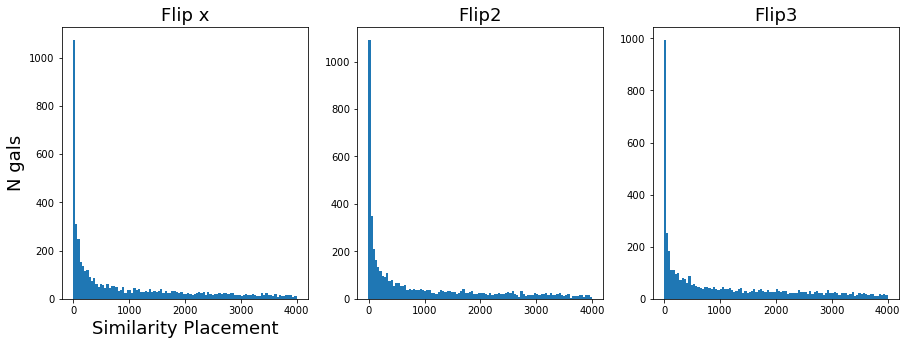

In [13]:
fig, ax = plt.subplots(1,3,figsize=(15,5),sharex=True)
a=0
sl = ['Flip x','Flip2','Flip3']
j=0
for augplacei in places:
    ax[j].hist(augplacei,bins=100,range=(-10,4000))
    #ax[j].set_xlim(-100,6000)
            #ax[i][j].set_xlabel('Placement')
    if a ==0:
        ax[j].set_title('%s' %sl[j],fontsize=18)
    ax[0].set_xlabel('Similarity Placement',fontsize=18)
    ax[0].set_ylabel('N gals',fontsize=18)

    j+=1
#plt.savefig('/external/grant/plots/summer/sim_placement_nomoco.png')

## Similarity placements with moco

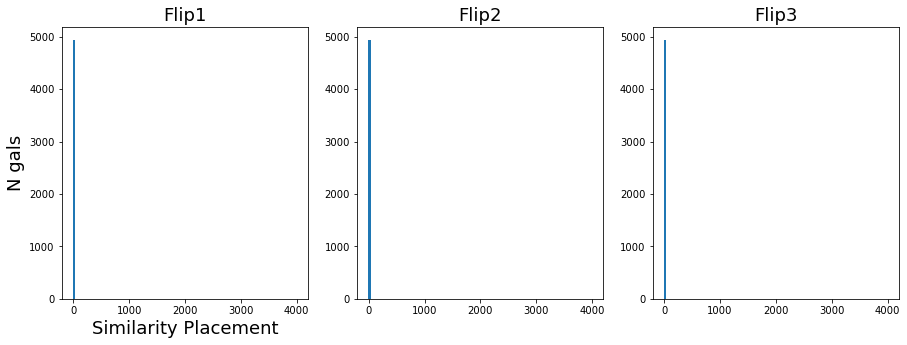

In [18]:
fig, ax = plt.subplots(1,3,figsize=(15,5),sharex=True)
a=0
sl = ['Flip1','Flip2','Flip3']
j=0
for augplacei in places:
    ax[j].hist(augplacei,bins=100,range=(-10,4000))
    #ax[j].set_xlim(-100,6000)
            #ax[i][j].set_xlabel('Placement')
    if a ==0:
        ax[j].set_title('%s' %sl[j],fontsize=18)
    ax[0].set_xlabel('Similarity Placement',fontsize=18)
    ax[0].set_ylabel('N gals',fontsize=18)

    j+=1
#plt.savefig('/external/grant/plots/summer/sim_placement_moco.png')

## Let's look at the nth most similar galaxies to a query galaxy

In [34]:
data = h5py.File('/external/grant/data/DR2/sorted_data_13_16.h5', 'r')
print("Data keys:", data.keys())
print("Images shape:", data['images'].shape)



Data keys: <KeysViewHDF5 ['images', 'obj_ids']>
Images shape: (4939, 5, 228, 228)


In [44]:
encoded=np.load('/external/grant/models/moco/DR2/withmoco_fits_mse_squash4_log_mask_beta50/fits_encoded.npy')
nq=0
ith=4
search = similarities(ith,encoded,nq)



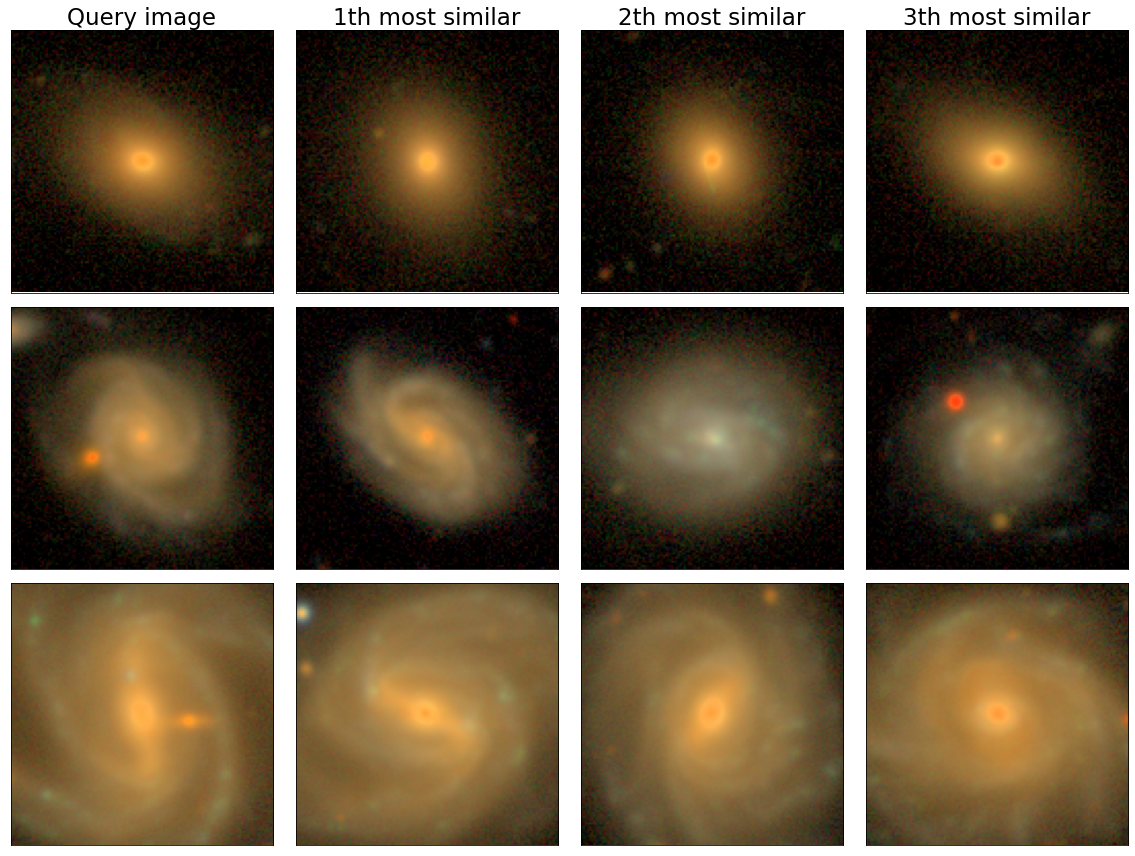

In [88]:

size=4
randti = np.random.randint(0,data['images'].shape[0],size=size)

randti[0]=1047
randti[2]=1431

m_ind1 = search.cos_dist(randti[0])
m_ind2 = search.cos_dist(randti[1])
m_ind3 = search.cos_dist(randti[2])

#m_ind1 = search.cos_dist(aug1ind[57])
#m_ind2 = search.cos_dist(aug1ind[68])
#m_ind3 = search.cos_dist(aug1ind[400])


#m_ind1 = neigh.kneighbors([encoded_test[randti[0]]], 4, return_distance=False)[0]
#m_ind2 = neigh.kneighbors([encoded_test[randti[1]]], 4, return_distance=False)[0]
#m_ind3 = neigh.kneighbors([encoded_test[randti[2]]], 4, return_distance=False)[0]

plt.figure(figsize=(ith*4,12))
for sp, e_i in enumerate(m_ind1):
    ax = plt.subplot(3, ith, sp+1,yticks=[],xticks=[])
    if sp+1==1:
        plt.title('Query image',fontsize=23)
    else:
        plt.title('%dth most similar' %(sp),fontsize=23)
    plt.imshow(luptonize(data['images'][e_i][:,50:178,50:178]))
for sp, m_i in enumerate(m_ind2):
    ax = plt.subplot(3, ith, sp+ith+1,yticks=[],xticks=[])
    plt.imshow(luptonize(data['images'][m_i][:,50:178,50:178]))
for sp, c_i in enumerate(m_ind3):
    ax = plt.subplot(3, ith, sp+2*ith+1,yticks=[],xticks=[])
    plt.imshow(luptonize(data['images'][c_i][:,50:178,50:178]))
plt.tight_layout()
#plt.show()


plt.savefig('/external/grant/plots/sim_search.png')